In [76]:
##### IMPORT ALL PACKAGES #####
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pandasql import sqldf
%matplotlib inline
pysqldf = lambda q: sqldf(q, globals())

##### IMPORT ALL DATA #####
df_imdb_name_basics = pd.read_csv('data/imdb.name.basics.csv')
df_imdb_title_akas = pd.read_csv('data/imdb.title.akas.csv')
df_imdb_title_basics = pd.read_csv('data/imdb.title.basics.csv') # PRIMARY
df_imdb_title_crew = pd.read_csv('data/imdb.title.crew.csv')
df_imdb_title_principals = pd.read_csv('data/imdb.title.principals.csv')
df_imdb_title_ratings = pd.read_csv('data/imdb.title.ratings.csv') # PRIMARY
df_rt_movie_info = pd.read_csv('data/rt.movie_info.tsv', delimiter = '\t')
df_rt_reviews = pd.read_csv('data/rt.reviews.tsv', delimiter = '\t', encoding= 'unicode_escape')
df_tmdb_movies = pd.read_csv('data/tmdb.movies.csv').drop('Unnamed: 0', axis=1)
df_tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')
df_tn_top_directors = pd.read_csv('data/tn.top_directors.csv', encoding= 'unicode_escape') #source: https://www.the-numbers.com/box-office-star-records/worldwide/lifetime-specific-technical-role/director

##### GENRES #####
GENRES_OG = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
GENRES_FULL = [
     'genre_action','genre_adult','genre_adventure','genre_animation','genre_biography','genre_comedy','genre_crime',
     'genre_documentary','genre_drama','genre_family','genre_fantasy','genre_gameshow','genre_history','genre_horror',
     'genre_music','genre_musical','genre_mystery','genre_news','genre_reality_tv','genre_romance','genre_sci_fi',
     'genre_short','genre_sport','genre_talkshow','genre_thriller','genre_war','genre_western']
GENRE_CONVERSION = dict(zip(GENRES_FULL, GENRES_OG))

##### COMBINE AND CLEAN FINANCIAL DATA #####
df_money = df_tn_movie_budgets.loc[:, ['movie', 'production_budget', 'domestic_gross','worldwide_gross']].copy()
production_budget = [float(x.replace('$', '').replace(',','')) for x in df_money.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in df_money.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in df_money.worldwide_gross]
df_money = pd.DataFrame([production_budget, domestic_gross, worldwide_gross]).transpose()
df_money.columns = ['production_budget', 'domestic_gross', 'worldwide_gross']
df_money['profit'] = df_money.worldwide_gross - df_money.production_budget
df_money['movie'] = df_tn_movie_budgets.movie
df_money = df_money[['movie','production_budget', 'domestic_gross', 'worldwide_gross', 'profit']]
df_money = df_money.sort_values(by='movie').reset_index(drop=True)
df_genres = df_imdb_title_basics[df_imdb_title_basics['genres'].isna() == False].copy()
for category in GENRES_OG:
    df_genres[category] = [category in x for x in df_genres['genres']]
df_genres.drop(['start_year', 'runtime_minutes', 'genres', 'original_title'], axis=1, inplace=True)

##### CREATE FULL IMDB DB #####
df_imdb = pysqldf(''' SELECT * FROM df_imdb_title_basics basics
LEFT JOIN df_genres genres USING (tconst)
LEFT JOIN df_money money ON basics.primary_title == money.movie
LEFT JOIN df_tmdb_movies tmdb ON basics.primary_title == tmdb.original_title;''')

df_imdb = df_imdb[[
       'tconst', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 
       'production_budget', 'domestic_gross', 'worldwide_gross', 'profit',
       'genre_ids', 'id', 'original_language', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count',
       'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']]
df_imdb.columns = ['tconst', 'primary_title', 'DELETE1', 'original_title',
       'DELETE2', 'start_year', 'runtime_minutes', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'profit', 'genre_ids', 'id_tmdb',
       'original_language', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'genre_action', 'genre_adult', 'genre_adventure',
       'genre_animation', 'genre_biography', 'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
       'genre_family', 'genre_fantasy', 'genre_gameshow', 'genre_history', 'genre_horror', 'genre_music',
       'genre_musical', 'genre_mystery', 'genre_news', 'genre_reality_tv', 'genre_romance', 'genre_sci_fi',
       'genre_short', 'genre_sport', 'genre_talkshow', 'genre_thriller', 'genre_war', 'genre_western']
df_imdb.drop(['DELETE1', 'DELETE2'], axis=1, inplace=True)

In [77]:
##### CLEANUPS #####
path = os.path.join('cleaning_dicts','cleaning_lookup_rt_studios.csv')
studio_cleanup_df = pd.read_csv(path)
STUDIO_CLEANUP_DICT = dict(zip(studio_cleanup_df.old, studio_cleanup_df.new))

path = os.path.join('cleaning_dicts','cleaning_lookup_rt_ratings.csv')
rating_cleanup_df = pd.read_csv(path)
RATING_CLEANUP_DICT = dict(zip(rating_cleanup_df.old, rating_cleanup_df.new))

df_rt_reviews['rating'] = df_rt_reviews['rating'].map(RATING_CLEANUP_DICT)
df_rt_reviews['fresh'] = df_rt_reviews['fresh'].map({'fresh':1, 'rotten':0}) #convert fresh/rotten text to binary 1/0
df_rt_reviews.drop(['review', 'publisher'], axis=1, inplace=True)

In [78]:
df_rt_reviews.head(3)

,id,rating,fresh,critic,top_critic,date
0,3,6.0,1,PJ Nabarro,0,"November 10, 2018"
1,3,NaN,0,Annalee Newitz,0,"May 23, 2018"
2,3,NaN,1,Sean Axmaker,0,"January 4, 2018"


In [79]:
##### CALCULATE THE AVERAGE 'FRESH' RATING FOR EACH MOVIE ID
MINIMUM_FRESHOMETER = 0#5 #minimum number of reviews to be considered


freshness = pd.DataFrame([df_rt_reviews.id.unique()], index=['id']).transpose()
#rating =    pd.DataFrame([df_rt_reviews.id.unique()], index=['id']).transpose().copy()
for movie_id in freshness['id']:
    fresh =  df_rt_reviews.loc[df_rt_reviews['id'] == movie_id, 'fresh']
    rating = df_rt_reviews.loc[df_rt_reviews['id'] == movie_id, 'rating']
    #if df_rt_reviews.loc[df_rt_reviews['id'] == movie_id, 'fresh'].size >= MINIMUM_FRESHOMETER:
    freshness.loc[freshness['id'] == movie_id, 'fresh'] = fresh.mean() #INDENTED
    freshness.loc[freshness['id'] == movie_id, 'rating'] = rating.mean()#INDENTED
#freshness = freshness.dropna()
rating = rating#.dropna()
df_rt_movie_info = df_rt_movie_info.drop(['synopsis', 'runtime', 'rating', 'dvd_date', 'currency', 'rating'], axis=1)

#freshness.shape
rating.shape
# rating

(38,)

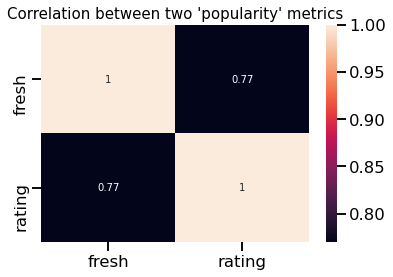

In [80]:
columns = {'id', 'rating', 'fresh'}
freshness = pd.DataFrame(columns=columns)
ids = df_rt_reviews.id.unique()

for id_ in ids:
    same_id = (df_rt_reviews['id'] == id_)
    
    fresh = df_rt_reviews.loc[same_id, 'fresh'].median()
    rating = df_rt_reviews.loc[same_id, 'rating'].median()
    #box_office_sum = df_rt.loc[same_studio, 'box_office'].sum()
    #box_office_median = df_rt.loc[same_studio, 'box_office'].median()
    #movie_ct = df_rt.loc[same_studio, 'studio'].size
    
    new_row = {'id': id_, 
               'fresh': fresh, 
               'rating': rating}

    freshness = freshness.append([new_row])
    
freshness.fresh.unique()

corrMatrix = freshness[['fresh', 'rating']].corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between two 'popularity' metrics", fontsize=15)
plt.show()

In [81]:
##### CLEAN 'BOX OFFICE' AND 'STUDIO' COLUMNS #####

df_rt = pysqldf(''' 
SELECT * FROM df_rt_movie_info main
LEFT JOIN freshness reviews USING (id);''')

df_rt.fillna(value=np.nan, inplace=True) # convert "None" values/types to NaN for easier manipulation and consistency
df_rt['box_office'] = df_rt['box_office'].str.replace(',','')
df_rt['box_office'] = [float(x) for x in df_rt['box_office']]
df_rt['studio'] = df_rt['studio'].map(STUDIO_CLEANUP_DICT).fillna(df_rt['studio'])

df_rt

,id,genre,director,writer,theater_date,box_office,studio,rating,fresh
0,1,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971",NaN,NaN,NaN,NaN
1,3,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012",600000.0,Entertainment One,6.0000,1.0
2,5,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996",NaN,NaN,6.2500,1.0
3,6,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994",NaN,NaN,6.0000,1.0
4,7,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1555,1996,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006",33886034.0,New Line Cinema,6.0000,1.0
1556,1997,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993",NaN,Paramount,4.0835,0.0
1557,1998,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962",NaN,NaN,6.0000,1.0
1558,1999,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993",NaN,NaN,6.0000,1.0


Text(0.5, 1.0, 'Correlation between various studio metrics')

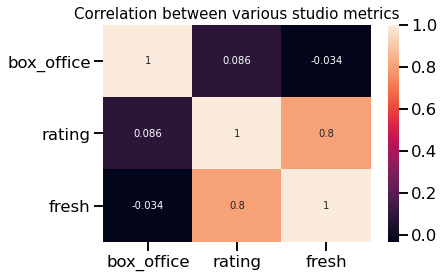

In [82]:
#TEMP FOR BOX

corrMatrix = df_rt[['box_office', 'rating', 'fresh']].dropna().corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between various studio metrics", fontsize=15)

In [83]:
##### CREATE DATAFRAME CONTAINING METRICS FOR SUCCESSFUL STUDIOS #####
MIN_FILMS = 5

columns = {'studio', 'box_office_median', 'box_office_sum', 'movie_ct', 'fresh'}
df_studios = pd.DataFrame(columns=columns)
studios = df_rt['studio'].unique()[1:]

for studio in studios:
    same_studio = (df_rt['studio'] == studio)

    fresh = df_rt.loc[same_studio, 'fresh'].median()
    box_office_sum = df_rt.loc[same_studio, 'box_office'].sum()
    box_office_median = df_rt.loc[same_studio, 'box_office'].median()
    movie_ct = df_rt.loc[same_studio, 'studio'].size
    
    new_row = {'studio': studio, 
               'fresh': fresh, 
               'box_office_median': box_office_median, 
               'box_office_sum': box_office_sum, 
               'movie_ct': movie_ct}

    df_studios = df_studios.append([new_row])
    
df_studios = df_studios.loc[df_studios['movie_ct']>=MIN_FILMS].copy()
df_studios.head(3)

,box_office_median,box_office_sum,studio,fresh,movie_ct
0,33670798.0,1.227998e+09,Warner Bros.,1.0,35
0,22715908.0,1.298615e+09,Paramount,0.0,37
0,9908198.5,1.236507e+09,Sony Pictures,1.0,45


<function matplotlib.pyplot.show(*args, **kw)>

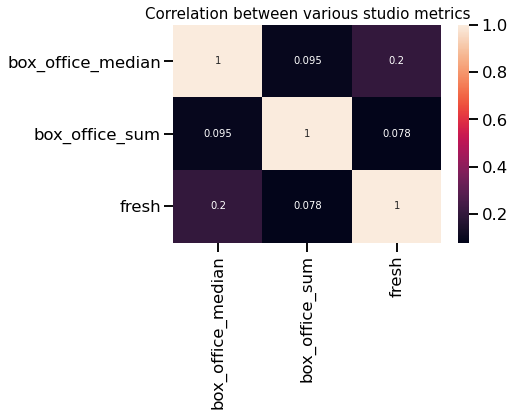

In [84]:
df = df_studios.drop('studio', axis=1)
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between various studio metrics", fontsize=15)
plt.show

In [85]:
##### ANALYZE DATA BY DIRECTOR #####

#Import cleanup dictionary
path = os.path.join('cleaning_dicts','cleaning_lookup_rt_directors.csv')
director_cleanup_df = pd.read_csv(path)
DIRECTOR_CLEANUP_DICT = dict(zip(director_cleanup_df.old, director_cleanup_df.new))

#Apply cleaning dictionary
director = df_rt['director']
df_rt['director'] = director.map(DIRECTOR_CLEANUP_DICT).fillna(director)

director_counts_dict = {}
directors = df_rt['director'].loc[df_rt['director'].isna()==False]
for name in directors:
    for name_split in name.split(sep = '|'):
        if name_split in director_counts_dict.keys():
            director_counts_dict[name_split] += 1
        else:
            director_counts_dict[name_split] = 1

director_counts_df = pd.Series(director_counts_dict).sort_values(ascending=False)

director_counts_df.head(10)

Steven Spielberg    10
Clint Eastwood       8
William Friedkin     4
Jim Jarmusch         4
Bruce Beresford      4
William Beaudine     4
Alfred Hitchcock     4
George Cukor         4
Ridley Scott         4
Curtis Hanson        4
dtype: int64

In [86]:
def clean_from_external_dict(path, series):
    df = pd.read_csv(path)
    cleaning_dict = dict(zip(df.old, df.new))
    x = df_rt['writer']
    return series.map(cleaning_dict).fillna(series)
    
    
path = os.path.join('cleaning_dicts','cleaning_lookup_rt_writers.csv')
series = df_rt['writer']

In [87]:
##### CLEANUP WRITER DATA #####
#### NOTE: THE EXTERNAL DICT FILE DOESN'T CONTAIN ANY DATA ATM. MUST BE CREATED IF YOU WANT 
####       TO RUN THIS AS PART OF THE FINAL ANALYSIS



# # path = os.path.join('cleaning_dicts','cleaning_lookup_rt_writers.csv')

# # clean_data(path)
# # writer_cleanup_df = pd.read_csv(path)
# # WRITER_CLEANUP_DICT = dict(zip(writer_cleanup_df.old, writer_cleanup_df.new))

# # writer = df_rt['writer']
# # df_rt['writer'] = writer.map(WRITER_CLEANUP_DICT).fillna(writer)

# writer_counts_dict = {}
# writers = df_rt.writer.loc[df_rt.writer.isna()==False]
# for writer in writers:
#     for writer_split in writer.split(sep = '|'):
#         if writer_split in writer_counts_dict.keys():
#             writer_counts_dict[writer_split] += 1
#         else:
#             writer_counts_dict[writer_split] = 1

# writer_counts_df = pd.Series(writer_counts_dict).sort_values(ascending=False)


# # df_rt['writer'] = df_rt['writer'].map(WRITER_CLEANUP_DICT).fillna(df_rt['writer'])
# # df_rt

# writer_counts_df.loc[writer_counts_df>2]

In [88]:
##### UNUSED??? #####

# df_tn_top_directors = pd.read_csv('data/tn.top_directors.csv', encoding= 'unicode_escape')

# MIN_MOVIE_CT = 10
# OUT_OF_SERVICE = ['Clint Eastwood']

# for i, director in enumerate(OUT_OF_SERVICE):
#     index_director = df_tn_top_directors.loc[df_tn_top_directors.name==OUT_OF_SERVICE[i]].index
#     df_tn_top_directors.drop(index=index_director, inplace=True)
    
# df_tn_top_directors = df_tn_top_directors.loc[(df_tn_top_directors.movies>=MIN_MOVIE_CT)]

# df_tn_top_directors = df_tn_top_directors.iloc[0:10].sort_values(by='worldwide_box_office')
# plt.barh(df_tn_top_directors.name, df_tn_top_directors.average)

<function matplotlib.pyplot.show(*args, **kw)>

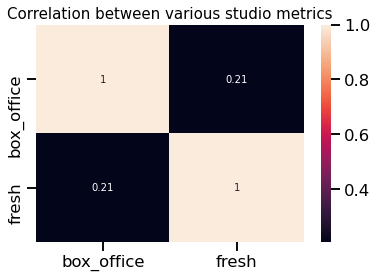

In [89]:
##### IGNORE THIS FOR NOW -- PROBABLY BETTER REPRESENTED BY IMDB DATA #####

df = df_rt[['id', 'genre', 'box_office', 'fresh']].dropna().reset_index(drop=True)
TESTER = df.head(7)

df
QUANTILE = 0#.1
df = df.loc[(df.box_office >= df.box_office.quantile(QUANTILE)) & (df.box_office <= df.box_office.quantile(1-QUANTILE))].copy()
df = df.loc[(df.fresh >= df.fresh.quantile(QUANTILE)) & (df.fresh <= df.fresh.quantile(1-QUANTILE))].copy()


rt_drop = ['Adult', 'Crime', 'Documentary', 'Drama', 'Game-Show', "Reality-TV", 'Short', 'Sport', 'Talkshow', 'Thriller', 'War']

for droppable in rt_drop:
    or_list = []
    for g in df.genre:
        split = g.split('|')
        #print('split: ',split)
        or_func = False
        for s in split:
            #print(f'{droppable} in {s}: ',droppable in s)
            or_func = or_func or (droppable in s)
        #print('OR FUNCTION: ', or_func)
        or_list.append(or_func)
    #print('OR LIST: ', or_list)
        
    #ESTER.loc[]
    df = df.drop(df[or_list].index)
    #print('------------------------------ NEXT LINE -----------------------------')
    
#TESTER.drop(index = or_list, axis=0)
    
    
#df.drop(df[df['c3'] == False].index, inplace=True)
    
df#[or_list]
x = df.fresh
y = df.box_office
# use the function regplot to make a scatterplot
sns.regplot(x,y)
#sns.plt.show()
 
# # Without regression fit:
# #sns.regplot(x=df["sepal_length"], y=df["sepal_width"], fit_reg=False)
# #sns.plt.show()


# #df_rt.genre
# df_genres.columns

# imdb_drop_4_profit = ['Crime', 'Reality_tv', 'Western', 'Sport', 'Drama', 'Thriller']
# imdb_drop_4_pop = ['Adult', 'Gameshow', 'War', 'Talkshow', 'Documentary', 'Short']
# imdb_drop = imdb_drop_4_profit + imdb_drop_4_pop
# imdb_drop



#df = df_studios.drop('studio', axis=1)
corrMatrix = df[['box_office', 'fresh']].corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between various studio metrics", fontsize=15)
plt.show

# definition of low/medium/high correlation:
# https://www.andrews.edu/~calkins/math/edrm611/edrm05.htm

<function matplotlib.pyplot.show(*args, **kw)>

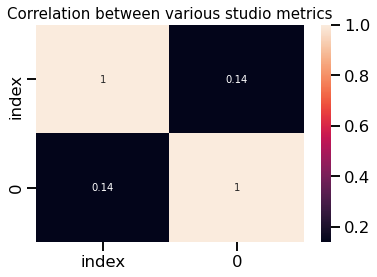

In [90]:
##### TESTING ONLY #####

manually_decided_these_fit_in_imdb_cats = [
'Comedy',
'Comedy|Kids and Family|Romance',
'Comedy|Romance',
'Horror|Mystery and Suspense',
'Comedy|Kids and Family',
'Action and Adventure|Comedy|Kids and Family',
'Horror',
'Action and Adventure|Animation|Comedy|Kids and Family',
'Action and Adventure|Mystery and Suspense',
'Action and Adventure|Horror',
'Animation|Comedy|Kids and Family',
'Action and Adventure|Art House and International',
'Action and Adventure|Animation|Comedy',
'Action and Adventure|Mystery and Suspense|Romance',
'Animation|Kids and Family',
'Comedy|Mystery and Suspense',
'Art House and International|Comedy|Romance',
'Kids and Family|Musical and Performing Arts',
'Action and Adventure|Animation|Kids and Family',
'Action and Adventure',
'Action and Adventure|Comedy',
'Action and Adventure|Horror|Mystery and Suspense',
'Animation|Comedy']


df = df_rt[['genre', 'box_office', 'fresh']].dropna().reset_index(drop=True)

box_office = []
fresh = []
genre_in_df = list(df.genre)
bo_in_df = list(df.box_office)
fresh_in_df = list(df.fresh)


for i, genre in enumerate(genre_in_df):
    if genre in manually_decided_these_fit_in_imdb_cats:
        box_office.append(bo_in_df[i])
        fresh.append(fresh_in_df[i])

x = fresh
y = box_office
# use the function regplot to make a scatterplot
sns.regplot(x,y)
#sns.plt.show()


#corrMatrix = df[['box_office', 'fresh']].corr()



corrMatrix = pd.DataFrame(box_office, fresh).reset_index().corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between various studio metrics", fontsize=15)
plt.show


# # # Without regression fit:
# # #sns.regplot(x=df["sepal_length"], y=df["sepal_width"], fit_reg=False)
# # #sns.plt.show()


# # #df_rt.genre
# # df_genres.columns

# # imdb_drop_4_profit = ['Crime', 'Reality_tv', 'Western', 'Sport', 'Drama', 'Thriller']
# # imdb_drop_4_pop = ['Adult', 'Gameshow', 'War', 'Talkshow', 'Documentary', 'Short']
# # imdb_drop = imdb_drop_4_profit + imdb_drop_4_pop
# # imdb_drop



# #df = df_studios.drop('studio', axis=1)
# corrMatrix = df[['box_office', 'fresh']].corr()
# sns.heatmap(corrMatrix, annot=True)
# plt.title("Correlation between various studio metrics", fontsize=15)
# plt.show

In [91]:
##### CURRENTLY UNUSED #####

genre_counts = {}
for item in df_rt_movie_info.genre.loc[df_rt_movie_info.genre.isna()==False]:
    for sub_item in item.split(sep = '|'):
        if sub_item in genre_counts.keys():
            genre_counts[sub_item] += 1
        else:
            genre_counts[sub_item] = 1
genre_counts = pd.Series(genre_counts).sort_values(ascending=False)

# Plot of Director Performance

https://seaborn.pydata.org/examples/palette_choices.html

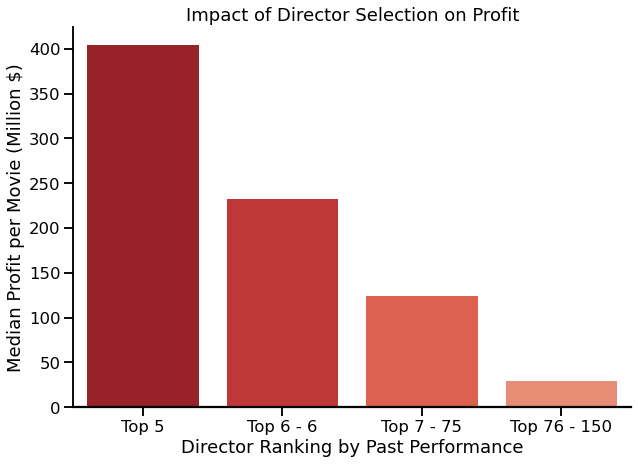

In [130]:
##### PERFORMANCE OF TOP DIRECTORS VS OTHERS #####

top_directors = df_tn_top_directors

MIN_MOVIE_CT = 1000
NUMBER_TO_INCLUDE = 500
OUT_OF_SERVICE = ['Clint Eastwood']

for i, director in enumerate(OUT_OF_SERVICE):
    index_director = top_directors.loc[top_directors.name==OUT_OF_SERVICE[i]].index
    top_directors.drop(index=index_director, inplace=True)


# only producers with production +1stddev from median performance
# as this is an indicator of a bredth of experience relative to peers
movies = df_tn_top_directors.movies
MIN_MOVIE_CT = movies.std() + movies.median()
top_directors = df_tn_top_directors.loc[df_tn_top_directors['movies'] > MIN_MOVIE_CT]

# tiers 
t1 = 5
t2 = 6
t3 = 75
t4 = 150

tier1 = top_directors.iloc[0: t1]['average'].mean()/10**6
tier2 = top_directors.iloc[t1: t2]['average'].mean()/10**6
tier3 = top_directors.iloc[t2: t3]['average'].mean()/10**6
tier4 = top_directors.iloc[t3:]['average'].mean()/10**6


sns.set_context('talk') 
palette = sns.color_palette("Reds_r")
f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)

x = [f'Top {t1}', 
     f'Top {t1+1} - {t2}', 
     f'Top {t2+1} - {t3}', 
     f'Top {t3+1} - {t4}']

y = [tier1, tier2, tier3, tier4]

sns.barplot(x=x, y=y, ax=ax, palette=palette)
ax.axhline(0, color="k", clip_on=False)
ax.set_xlabel('Director Ranking by Past Performance')
ax.set_ylabel("Median Profit per Movie (Million $)")
ax.set_title('Impact of Director Selection on Profit')
sns.despine(bottom=True)
plt.savefig('images/Impact of Director Selection on Profit.png')

In [93]:
top_directors

,rank,name,worldwide_box_office,movies,average
0,1,Steven Spielberg,10548165432,36,293004595
3,4,Peter Jackson,6535735207,14,466838229
4,5,Michael Bay,6443668115,16,402729257
5,6,James Cameron,6234449998,14,445317857
7,8,Christopher Nolan,4962078794,12,413506566
...,...,...,...,...,...
963,964,Paul Schrader,100209958,15,6680664
969,970,Roland Joffe,99263658,12,8271972
976,977,John Ford,97209803,14,6943557
982,983,Takashi Miike,96797438,21,4609402


In [125]:
table = top_directors[['name']].iloc[:5]
table.index = range(1,6)
table.columns = ['Top Directors']
table

,Top Directors
1,Steven Spielberg
2,Peter Jackson
3,Michael Bay
4,James Cameron
5,Christopher Nolan
